## **Brain Tumor Classification**

Baseline model

## **1 Setup**

### **1.1 Imports**

In [1]:
# Import neccessary libraries
import pathlib
import os
import numpy as np
import pandas as pd
from collections import Counter
import PIL.Image as image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

### **1.2 Constants**

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 240
CLASS_MODE_SPARSE = 'sparse'
INTERPOLATION_BILINEAR = 'bilinear'
SEED = 1234

## **2 Load dataset**

### **2.1 Clone data on Google Colab**

In [3]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 8.14 MiB/s, done.


In [4]:
!ls /content/Brain-Tumor-Classification-DataSet/

Testing  Training


In [5]:
# Train set and test set data directory
train_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Training')
test_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Testing')

In [6]:
# Number of images in train set and test set
train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(f'There are {train_image_count} images in training dataset.')
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(f'There are {test_image_count} images in testing dataset.')

There are 2870 images in training dataset.
There are 394 images in testing dataset.


### **2.2 Load image files to Keras**

### **2.2.1 Load train, validation, and test datasets into Keras**

---



We will reserve 20% of the training data for validation.

In [7]:
# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset='training',
    image_size=(IMG_SIZE, IMG_SIZE),
    seed = SEED,
    batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [8]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset='validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    seed = SEED,
    batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [9]:
# Testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    validation_split=None,
    subset=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 394 files belonging to 4 classes.


In [10]:
# Classes  
class_names = train_ds.class_names
num_classes = len(class_names)
print(f'There are {num_classes} classes.')
print(f'The names of the classes are {class_names}.')

There are 4 classes.
The names of the classes are ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'].


### **2.2.2 Class distribution in each dataset**

In [11]:
# Function returns the count of class labels
def return_class_labels(ds):
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

train_labels_count = Counter(return_class_labels(train_ds))
print("The distribution of training labels is: ", train_labels_count)

val_labels_count = Counter(return_class_labels(val_ds))
print("The distribution of validation labels is: ", val_labels_count)

test_labels_count = Counter(return_class_labels(test_ds))
print("The distribution of test labels is: ", test_labels_count)

The distribution of training labels is:  Counter({0: 668, 1: 657, 3: 656, 2: 315})
The distribution of validation labels is:  Counter({3: 171, 1: 165, 0: 158, 2: 80})
The distribution of test labels is:  Counter({1: 115, 2: 105, 0: 100, 3: 74})


In [12]:
# Function to plot the class distribution
def plot_class_distribution(labels_count, title):

    distribution = pd.DataFrame.from_dict(labels_count.items())
    distribution.rename({0: 'Class', 1: 'Count'}, axis=1, inplace=True)
    distribution.set_index('Class', inplace=True)
    distribution.sort_index(inplace=True)
    distribution.rename(index={0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}, inplace=True)
    
    f, ax = plt.subplots(figsize=(15,5))
    sns.set_theme()
    sns.barplot(x=distribution.index, y=distribution.Count, data=distribution)
    plt.xlabel('Brain Tumor Classes')
    plt.title(title)

    # display values atop bars
    for i, p in enumerate(ax.patches):
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + (p.get_height() * 0.015)
        value = '{:.0f}'.format(p.get_height())
        ax.text(_x, _y, value, ha="center")

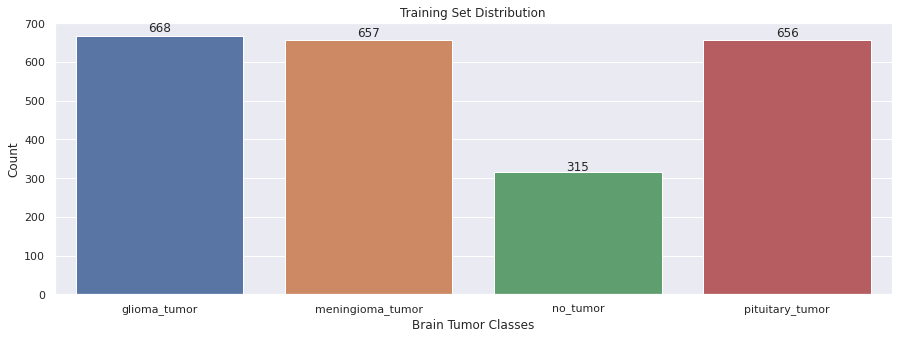

In [14]:
plot_class_distribution(train_labels_count, 'Training Set Distribution')

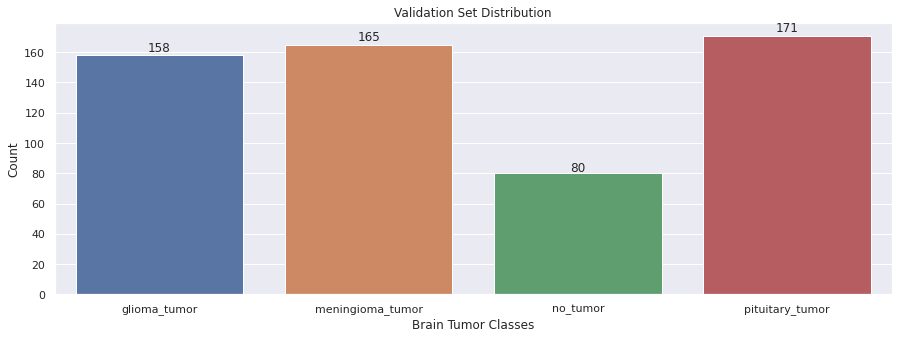

In [15]:
plot_class_distribution(val_labels_count, 'Validation Set Distribution')

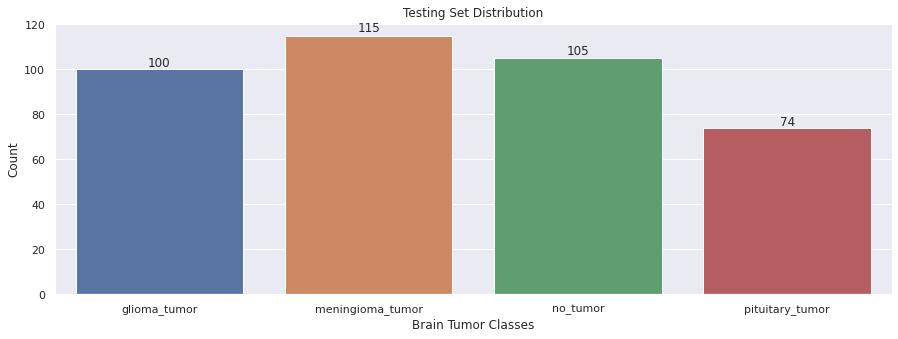

In [16]:
plot_class_distribution(test_labels_count, 'Testing Set Distribution')

## **3 Data Visualization**

Display 4 sample images from each class in the training dataset.

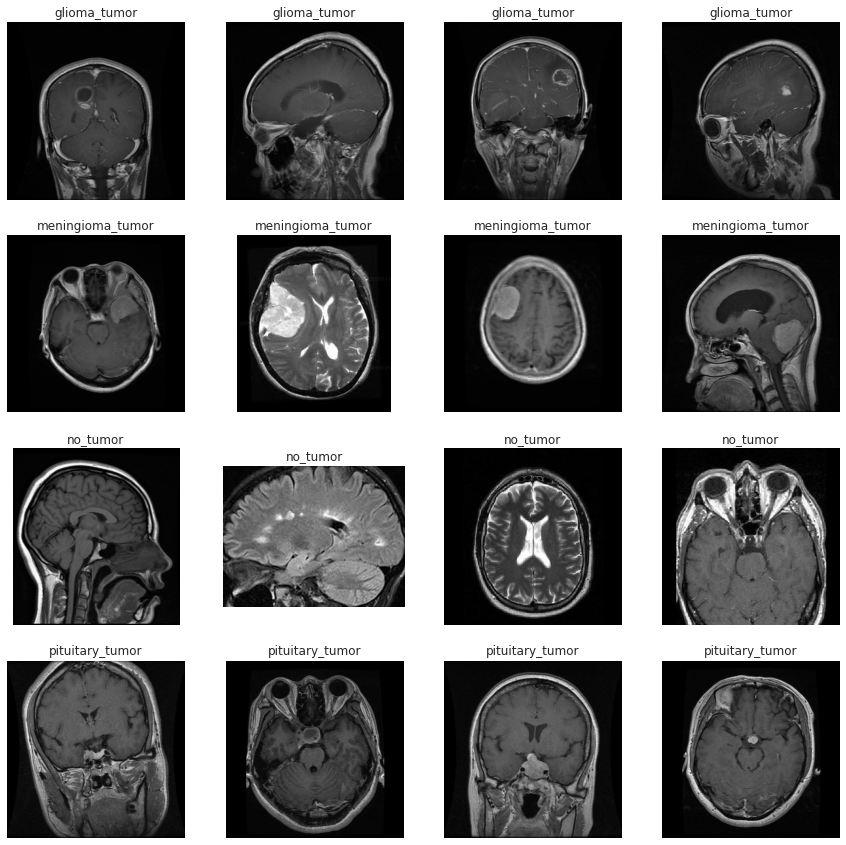

In [17]:
# Display 4 sample images from each class
plot_idx = 1
plt.figure(figsize=(15, 15))

for c in class_names:
    for i in range(4):
        ax = plt.subplot(4, 4, plot_idx+i)
        sample = list(train_data_dir.glob(str(c) + '/*'))
        im = image.open(str(sample[i]))
        plt.imshow(im)
        plt.title(c)
        plt.axis("off")
    plot_idx += 4

In [18]:
# Image size
img_width, img_height = image.open(str(sample[0])).size
print(f'The size of the images are {img_width} x {img_height}')

The size of the images are 512 x 512


## **4 Build baseline model**

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# Build a baseline model
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    tf.keras.layers.Conv2D(24,3,padding="same", activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(24, 3, padding="same", activation="relu"),   
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [22]:
num_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)

Epoch 1/10
72/72 [==============================] - 22s 73ms/step - loss: 0.8614 - accuracy: 0.6315 - val_loss: 0.5704 - val_accuracy: 0.7979
Epoch 2/10
72/72 [==============================] - 2s 22ms/step - loss: 0.3543 - accuracy: 0.8698 - val_loss: 0.5297 - val_accuracy: 0.8449
Epoch 3/10
72/72 [==============================] - 2s 22ms/step - loss: 0.2186 - accuracy: 0.9229 - val_loss: 0.6946 - val_accuracy: 0.7944
Epoch 4/10
72/72 [==============================] - 2s 22ms/step - loss: 0.1460 - accuracy: 0.9490 - val_loss: 0.6654 - val_accuracy: 0.8118
Epoch 5/10
72/72 [==============================] - 2s 22ms/step - loss: 0.1116 - accuracy: 0.9604 - val_loss: 0.6774 - val_accuracy: 0.8084
Epoch 6/10
72/72 [==============================] - 2s 22ms/step - loss: 0.1002 - accuracy: 0.9643 - val_loss: 0.4198 - val_accuracy: 0.8641
Epoch 7/10
72/72 [==============================] - 2s 22ms/step - loss: 0.0689 - accuracy: 0.9769 - val_loss: 0.5709 - val_accuracy: 0.8537
Epoch 8/10
7

The train accuracy is 99.43% and the validation accuracy is 89.20%

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 240, 240, 24)      672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 24)      5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 86400)             0

## **5 Model Evaluation**

### **5.1 Training and validation accuracy and loss**

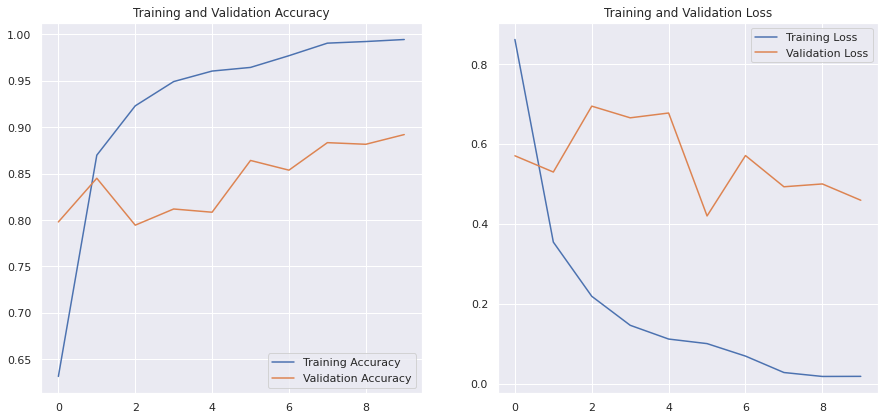

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **5.2 Accuracy comparision**

In [25]:
# Testing accuracy and loss
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)
print(f'The test accuracy is {test_accuracy*100:.2f}%')

13/13 - 1s - loss: 5.4072 - accuracy: 0.6853
The test accuracy is 68.53%


Accuracy comparison: <br>
Baseline model: <br>
Train accuracy 99.43% <br>
Validation accuracy: 89.20% <br>
Test accuracy: 68.53% <br><br>

### **5.3 Confusion matrix and classification report**

In [26]:
# Get the labels
true_labels = np.array([])
pred_labels = np.array([])

for x, y in test_ds:
    true_labels = np.concatenate([true_labels, y.numpy()])
    pred_labels = np.concatenate([pred_labels, np.argmax(model.predict(x), axis=-1)])

# Look at the first 10 predictions and labels
print('predictions = ', pred_labels[:10])
print('True labels = ', true_labels[:10])

predictions =  [0. 1. 2. 1. 1. 2. 1. 2. 1. 1.]
True labels =  [0. 0. 0. 0. 0. 0. 1. 3. 0. 1.]


In [27]:
# Verify the test accuracy
m = tf.keras.metrics.Accuracy()
m(true_labels, pred_labels).numpy()

0.6852792

In [28]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, pred_labels)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 17  37  46   0]
 [  0 107   6   2]
 [  0   1 104   0]
 [  0  22  10  42]], shape=(4, 4), dtype=int32)


In [29]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, pred_labels, target_names=class_names))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.17      0.29       100
meningioma_tumor       0.64      0.93      0.76       115
        no_tumor       0.63      0.99      0.77       105
 pituitary_tumor       0.95      0.57      0.71        74

        accuracy                           0.69       394
       macro avg       0.81      0.66      0.63       394
    weighted avg       0.79      0.69      0.63       394



From the confusion matrix and the classification report, we see that the model has pretty high recall rates on the no tumor class and meningioma class.  The recall rates of the pituitary tumor class and glioma tumor class are low, especially the glioma tumor class only has a recall rate of 0.17.

### **5.4 Save model performance**

In [30]:
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
performance = {'Model': [],
               'Train accuracy': [],
               'Train loss': [],
               'Test accuracy': [],
               'Test loss': [],
               'Glioma Precision': [],
               'Glioma Recall': [],
               'Meningioma Precision': [],
               'Meningioma Recall': [],
               'No Tumor Precision': [],
               'No Tumor Recall': [],
               'Pituitary Precision': [],
               'Pituitary Recall': []
               }

performance['Model'].append('Baseline model')
performance['Train accuracy'].append(acc[-1])
performance['Train loss'].append(loss[-1])
performance['Test accuracy'].append(test_accuracy)
performance['Test loss'].append(test_loss)
performance['Glioma Precision'].append(report['glioma_tumor']['precision'])
performance['Glioma Recall'].append(report['glioma_tumor']['recall'])
performance['Meningioma Precision'].append(report['meningioma_tumor']['precision'])
performance['Meningioma Recall'].append(report['meningioma_tumor']['recall'])
performance['No Tumor Precision'].append(report['no_tumor']['precision'])
performance['No Tumor Recall'].append(report['no_tumor']['recall'])
performance['Pituitary Precision'].append(report['pituitary_tumor']['precision'])
performance['Pituitary Recall'].append(report['pituitary_tumor']['recall'])

df_performance = pd.DataFrame(performance)
df_performance.to_csv('baseline_performance.csv', index=False)